# IMPORTS (+INSTALLATIONS AND SET-UP)

In [6]:
import os

# TAMING TRANSFORMERS REPOSITORY (FOR THE SYNTHETIC AERIAL GENERATION)
if not os.path.exists('/kaggle/working/taming-transformers'):
    print("Cloning taming-transformers repository...")
    !git clone https://github.com/CompVis/taming-transformers.git
    print("Repository cloned successfully!")
else:
    print("Repository already exists, skipping clone.")

# MOVE TO THE DIRECTORY (KAGGLE STARTS FROM THE ROOT DIRECTORY OF WORKING)
%cd taming-transformers

# DOWNGRADE PYTORCH & PYTORCH LIGHTNING
!pip install torch # ==1.7.0 
!pip install torchvision # ==0.8.1
!pip install pytorch-lightning # ==1.0.8

!pip install albumentations # ==0.4.3     # INSTALLS 'ALBUMENTATIONS', LIBRARY FOR IMAGE AUGMENTATION.
!pip install opencv-python #==4.1.2.30
!pip install omegaconf # ==2.0.0
!pip install einops # ==0.3.0
!pip install transformers==4.3.1

!pip install imageio # ==2.9.0
!pip install streamlit # >=0.73.1

#INFERED
!pip install tensorboard # ==2.2.0

#PACKAGE INSTALLATION
!pip install -e .

# INSTALLS THREE KEY LIBRARIES FROM HUGGING FACE:
# - 'TRANSFORMERS': PRE-TRAINED SEGFORMER MODEL ARCHITECTURE.
# - 'DATASETS':     STANDARD FOR LOADING DATASETS.
# - 'EVALUATE':     FOR PERFOMANCE METRIX
!pip install transformers datasets evaluate -q #  '-Q' IS FOR "QUIET", MINIMAL INSTALLATION OUTPUT

print ("-- INSTALLATION IS OVER --\n")

import torch                         #PYTORCH
from torch.utils.data import Dataset #CUSTOM DATASETS
import torch.nn as nn                #NN MODULE FROM PYTORCH
import torch.nn.functional as F      #FUNCTIONALS FROM PYTORCH
from torch import Tensor





import urllib.request

import torchvision.models as models  
import torchvision.transforms as transforms

# -----------------------------------------------------------------------
# COMPATIBILITY ISSUE 1: torch._six import
# -----------------------------------------------------------------------
utils_file = '/kaggle/working/taming-transformers/taming/data/utils.py'

# Read file
with open(utils_file, 'r') as f:
    content = f.read()

# Replace import
content = content.replace(
    'from torch._six import string_classes',
    'string_classes = str'
)

# Write back fixed file
with open(utils_file, 'w') as f:
    f.write(content)

print("Fixed torch._six import issue!")

# -----------------------------------------------------------------------

from taming.models.vqgan import VQModel
from taming.models.cond_transformer import Net2NetTransformer

import csv               #TO OPERATE ON CSV FILES
from pathlib import Path

from pathlib import Path # FOR FILE PATH 
import numpy as np       #NUMPY
from PIL import Image    #FOR IMAGES
import matplotlib.pyplot as plt #MATPLOTLIB
from tqdm import tqdm    #PROGRESS BARS

import albumentations as A #'ALBUMENTATIONS', LIBRARY FOR IMAGE AUGMENTATION.
from albumentations.pytorch import ToTensorV2 # A SPECIFIC ALBUMENTATIONS TRANSFORM TO CONVERT NUMPY ARRAYS INTO PYTORCH TENSORS.

import transformers
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor # SEMANTIC SEGMENTATION WITH A SEGFORMER ARCHITECTURE.

from omegaconf import OmegaConf #CONFIGURATION LIBRARY
import yaml



print("-- IMPORTS COMPLETE --\n")

# SET GPU IF AVAILABLE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Repository already exists, skipping clone.
[Errno 2] No such file or directory: 'taming-transformers'
/kaggle/working/taming-transformers
  Using cached transformers-4.3.1-py3-none-any.whl.metadata (36 kB)
  Using cached sacremoses-0.1.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached transformers-4.3.1-py3-none-any.whl (1.8 MB)
Using cached sacremoses-0.1.1-py3-none-any.whl (897 kB)
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
Obtaining file:///kaggle/working/t

# GLOBALS

In [7]:
# -----------------------------------------------------------------------
# FLAGS FOR TESTING
# -----------------------------------------------------------------------


ffninputshapetest=False
jflnshapetest=False
vgg16shapetest=False
phase2completeshapetest=False
tripletlosstest=False
dataset_test=False
vqgan_has_to_download=True
completesystemtest=True

if ffninputshapetest:
    print("FFN shape test expected.")

if jflnshapetest:
    print("JFLN shape test expected.")

if vgg16shapetest:
    print("VGG16 shape test expected.")

if phase2completeshapetest:
    print("Complete Phase 2 Networks shape test expected.")

if tripletlosstest:
    print("Triplet Loss test expected.")

if dataset_test:
    print("Dataset Test Expected.")


# -----------------------------------------------------------------------
# CONFIGURATION STRUCTURE -- PHASE 1 TRANSFORMER
# -----------------------------------------------------------------------

config = OmegaConf.create({
    "first_stage_config": {
        "target": "taming.models.vqgan.VQModel",
        "params": {
            "ckpt_path": "/kaggle/working/models/vqgan_imagenet_f16_16384.ckpt",
            "embed_dim": 256,
            "n_embed": 16384,
            "ddconfig": {
                "double_z": False,
                "z_channels": 256,
                "resolution": 256,
                "in_channels": 3,
                "out_ch": 3,
                "ch": 128,
                "ch_mult": [1, 1, 2, 2, 4],
                "num_res_blocks": 2,
                "attn_resolutions": [16],
                "dropout": 0.0
            },
            "lossconfig": {
                "target": "taming.modules.losses.DummyLoss"
            }
        }
    },
    "cond_stage_config": "__is_first_stage__",  # SAME VQGAN FOR BOTH IMAGES
    "transformer_config": {
        "target": "taming.modules.transformer.mingpt.GPT",
        "params": {
            "vocab_size": 16384,  # CODEBOOK SIZE
            "block_size": 512,    # Sequence length (for 16x16 = 256 tokens x2)
            "n_layer": 12,
            "n_head": 8,
            "n_embd": 512,
            # --- ADDED DROPOUT FOR REGULARIZATION ---
            "embd_pdrop": 0.2,    # Dropout on embeddings
            "resid_pdrop": 0.2,   # Dropout on residual connections
            "attn_pdrop": 0.2     # Dropout on attention weights
        }
    }
})

print("Phase 1 Transformer configuration created!")
print(f"VQ-GAN codebook size: {config.first_stage_config.params.n_embed}")
print(f"Transformer vocab size: {config.transformer_config.params.vocab_size}")


Phase 1 Transformer configuration created!
VQ-GAN codebook size: 16384
Transformer vocab size: 16384


# UTILS

In [8]:
# -----------------------------------------------------------------------
# COMPATIBILITY ISSUE 2: TOP K TOP P FILTERING
# -----------------------------------------------------------------------

def top_k_top_p_filtering(
    logits: Tensor,
    top_k: int = 0,
    top_p: float = 1.0,
    filter_value: float = -float("Inf"),
    min_tokens_to_keep: int = 1,
) -> Tensor:
    """Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
    Args:
        logits: logits distribution shape (batch size, vocabulary size)
        if top_k > 0: keep only top k tokens with highest probability (top-k filtering).
        if top_p < 1.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
    """
    if top_k > 0:
        top_k = min(max(top_k, min_tokens_to_keep), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
        sorted_indices_to_remove = cumulative_probs > top_p
        if min_tokens_to_keep > 1:
            # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
            sorted_indices_to_remove[..., :min_tokens_to_keep] = 0
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return logits

# INJECT FUNCTION INTO TRANSFORMERS MODULE
transformers.top_k_top_p_filtering = top_k_top_p_filtering
print("Real top_k_top_p_filtering function RE-added to transformers!")

# -----------------------------------------------------------------------
# COMPATIBILITY ISSUE 3: MANUAL FORWARD PASS INTEGRATION
# -----------------------------------------------------------------------
"""
def manual_forward_pass(model, satellite_imgs, ground_imgs):
    # Get raw encodings and fix reshaping
    _, z_indices_raw = model.encode_to_z(satellite_imgs)
    _, c_indices_raw = model.encode_to_c(ground_imgs)
    
    batch_size = satellite_imgs.shape[0]
    z_indices = z_indices_raw.view(batch_size, -1)
    c_indices = c_indices_raw.view(batch_size, -1)
    
    # Manual forward pass logic (from STEP-CHECKPOINT)
    cz_indices = torch.cat((c_indices, z_indices), dim=1)
    logits, _ = model.transformer(cz_indices[:, :-1])
    logits = logits[:, c_indices.shape[1]-1:]  # Cut off conditioning
    target = z_indices
    
    return logits, target

print("Manual Forward Pass integrated!")
"""


# -----------------------------------------------------------------------
# SYNTHETIC AERIAL TRANSFORMER FUNCTIONS
# -----------------------------------------------------------------------


#LOAD SAVED TRANSFORMER MODEL FOR AERIAL GENERATIONS
def load_saved_model(checkpoint_path, device='cuda', vqgan_checkpoint_path=None):
    """
    Load a model saved with your save_model_with_timestamp function
    
    Args:
        checkpoint_path: Path to the .pth checkpoint file
        device: Device to load the model on ('cuda' or 'cpu')
        vqgan_checkpoint_path: Optional path to VQ-GAN checkpoint (auto-detected if None)
    
    Returns:
        model: Loaded model ready for inference or continued training
        checkpoint_info: Dictionary with training information
    """
    
    # Check if checkpoint file exists
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")
    
    # Auto-detect device if CUDA not available
    if device == 'cuda' and not torch.cuda.is_available():
        print("CUDA not available, falling back to CPU")
        device = 'cpu'
    
    # Load checkpoint
    print(f"Loading checkpoint from: {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    except Exception as e:
        raise RuntimeError(f"Failed to load checkpoint: {e}")
    
    # Validate checkpoint structure
    required_keys = ['epoch', 'model_state_dict', 'model_config']
    missing_keys = [key for key in required_keys if key not in checkpoint]
    if missing_keys:
        raise ValueError(f"Checkpoint missing required keys: {missing_keys}")
    
    # Print checkpoint info
    print(f"Checkpoint info:")
    print(f"  - Epoch: {checkpoint['epoch']}")
    print(f"  - Loss: {checkpoint.get('loss', 'N/A')}")
    print(f"  - Timestamp: {checkpoint.get('timestamp', 'N/A')}")
    
    # Validate model config
    model_config = checkpoint['model_config']
    required_config_keys = ['transformer_vocab_size', 'transformer_block_size', 
                           'transformer_n_layer', 'transformer_n_head', 'transformer_n_embd']
    missing_config_keys = [key for key in required_config_keys if key not in model_config]
    if missing_config_keys:
        raise ValueError(f"Model config missing required keys: {missing_config_keys}")
    
    # Recreate the same configuration used in your notebook
    config = OmegaConf.create({
        "first_stage_config": {
            "target": "taming.models.vqgan.VQModel",
            "params": {
                "ckpt_path": None,  # We'll load this separately
                "embed_dim": 256,
                "n_embed": 16384,
                "ddconfig": {
                    "double_z": False,
                    "z_channels": 256,
                    "resolution": 256,
                    "in_channels": 3,
                    "out_ch": 3,
                    "ch": 128,
                    "ch_mult": [1, 1, 2, 2, 4],
                    "num_res_blocks": 2,
                    "attn_resolutions": [16],
                    "dropout": 0.0
                },
                "lossconfig": {
                    "target": "taming.modules.losses.DummyLoss"
                }
            }
        },
        "cond_stage_config": "__is_first_stage__",
        "transformer_config": {
            "target": "taming.modules.transformer.mingpt.GPT",
            "params": {
                "vocab_size": model_config['transformer_vocab_size'],
                "block_size": model_config['transformer_block_size'],
                "n_layer": model_config['transformer_n_layer'],
                "n_head": model_config['transformer_n_head'],
                "n_embd": model_config['transformer_n_embd'],
                # --- ADDED DROPOUT FOR REGULARIZATION ---
                "embd_pdrop": 0.2,    # Dropout on embeddings
                "resid_pdrop": 0.2,   # Dropout on residual connections
                "attn_pdrop": 0.2     # Dropout on attention weights
            }
        }
    })
    
    # Create the model
    try:
        model = Net2NetTransformer(
            transformer_config=config.transformer_config,
            first_stage_config=config.first_stage_config,
            cond_stage_config=config.cond_stage_config,
            first_stage_key="satellite",
            cond_stage_key="ground",
            unconditional=False
        )
        print("Model architecture created successfully")
    except Exception as e:
        raise RuntimeError(f"Failed to create model architecture: {e}")
    
    # Auto-detect VQ-GAN checkpoint path if not provided
    if vqgan_checkpoint_path is None:
        possible_paths = [
            "/kaggle/working/models/vqgan_imagenet_f16_16384.ckpt",
            "/kaggle/input/*/vqgan_imagenet_f16_16384.ckpt",
            "./models/vqgan_imagenet_f16_16384.ckpt",
            "/content/models/vqgan_imagenet_f16_16384.ckpt"  # For Colab
        ]
        
        # Use glob for wildcard paths
        for path_pattern in possible_paths:
            if '*' in path_pattern:
                matches = glob.glob(path_pattern)
                if matches:
                    vqgan_checkpoint_path = matches[0]
                    break
            elif os.path.exists(path_pattern):
                vqgan_checkpoint_path = path_pattern
                break
    
    # Load the VQ-GAN weights
    if vqgan_checkpoint_path and os.path.exists(vqgan_checkpoint_path):
        print(f"Loading VQ-GAN weights from: {vqgan_checkpoint_path}")
        try:
            vqgan_state = torch.load(vqgan_checkpoint_path, map_location=device, weights_only=False)
            
            # Check if the checkpoint has the expected structure
            if "state_dict" not in vqgan_state:
                raise ValueError("VQ-GAN checkpoint missing 'state_dict' key")
            
            model.first_stage_model.load_state_dict(vqgan_state["state_dict"], strict=False)
            
            # Freeze VQ-GAN parameters
            for param in model.first_stage_model.parameters():
                param.requires_grad = False
            print("VQ-GAN weights loaded and frozen!")
            
        except Exception as e:
            print(f"Failed to load VQ-GAN weights: {e}")
            print("Model will work but VQ-GAN may not be properly initialized")
    else:
        print("VQ-GAN checkpoint not found. You may need to:")
        print("   1. Download it again")
        print("   2. Provide the correct path via vqgan_checkpoint_path parameter")
        print("   3. Ensure the file exists in one of the expected locations")



    # CRITICAL FIX: Compile model BEFORE loading weights to match key structure
    try:
        model = torch.compile(model)
        print("Model compiled - keys now match saved model")
    except Exception as e:
        print(f"Model compilation failed: {e}")
        print("Continuing without compilation...")
    
    # Load the trained transformer weights
    print("Loading trained transformer weights...")
    try:
        # Load with strict=False to handle potential key mismatches
        missing_keys, unexpected_keys = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        
        if missing_keys:
            print(f"⚠️  Missing keys in checkpoint: {len(missing_keys)} keys")
            if len(missing_keys) <= 5:
                print(f"    {missing_keys}")
        if unexpected_keys:
            print(f"⚠️  Unexpected keys in checkpoint: {len(unexpected_keys)} keys")
            if len(unexpected_keys) <= 5:
                print(f"    {unexpected_keys}")
        
        print("Transformer weights loaded!")
        
    except Exception as e:
        raise RuntimeError(f"Failed to load transformer weights: {e}")
    
    # Move to device
    try:
        model = model.to(device)
        print(f"Model moved to {device}")
    except Exception as e:
        print(f"Failed to move model to {device}: {e}")
        print("Falling back to CPU...")
        device = 'cpu'
        model = model.to(device)
    
    print(f"Model loaded successfully on {device}")
    
    # Return model and checkpoint info
    checkpoint_info = {
        'epoch': checkpoint['epoch'],
        'loss': checkpoint.get('loss', None),
        'timestamp': checkpoint.get('timestamp', None),
        'model_config': checkpoint['model_config'],
        'device': device
    }
    
    return model, checkpoint_info

def load_with_optimizer(checkpoint_path, device='cuda', lr=5e-4, vqgan_checkpoint_path=None):
    """
    Load model with optimizer state for continued training
    
    Args:
        checkpoint_path: Path to the .pth checkpoint file
        device: Device to load the model on
        lr: Learning rate for optimizer (in case you want to change it)
        vqgan_checkpoint_path: Optional path to VQ-GAN checkpoint
    
    Returns:
        model: Loaded model
        optimizer: Optimizer with loaded state
        checkpoint_info: Dictionary with training information
    """
    # Load the model first
    model, checkpoint_info = load_saved_model(checkpoint_path, device, vqgan_checkpoint_path)
    
    # Create optimizer
    try:
        optimizer = torch.optim.AdamW(model.transformer.parameters(), lr=lr, betas=(0.9, 0.95))
        print("✅ Optimizer created")
    except Exception as e:
        raise RuntimeError(f"Failed to create optimizer: {e}")
    
    # Load checkpoint again to get optimizer state
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    except Exception as e:
        raise RuntimeError(f"Failed to reload checkpoint for optimizer: {e}")
    
    # Load optimizer state
    if 'optimizer_state_dict' in checkpoint:
        try:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("✅ Optimizer state loaded!")
        except Exception as e:
            print(f"⚠️  Failed to load optimizer state: {e}")
            print("Optimizer will use default initialization")
    else:
        print("⚠️  No optimizer state found in checkpoint")
    
    return model, optimizer, checkpoint_info

def find_latest_checkpoint(directory="/kaggle/working/", base_name="cvusa_ground2satellite"):
    """
    Find the latest checkpoint file in a directory
    
    Args:
        directory: Directory to search in
        base_name: Base name of the checkpoint files
    
    Returns:
        latest_checkpoint_path: Path to the latest checkpoint
    """
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory not found: {directory}")
    
    try:
        files = os.listdir(directory)
    except PermissionError:
        raise PermissionError(f"Permission denied accessing directory: {directory}")
    
    checkpoint_files = []
    
    for filename in files:
        if filename.startswith(base_name) and filename.endswith('.pth'):
            filepath = os.path.join(directory, filename)
            try:
                # Get file modification time
                mtime = os.path.getmtime(filepath)
                checkpoint_files.append((mtime, filepath, filename))
            except OSError as e:
                print(f"⚠️  Could not access file {filename}: {e}")
                continue
    
    if not checkpoint_files:
        raise FileNotFoundError(f"No checkpoint files found with base name '{base_name}' in {directory}")
    
    # Sort by modification time (newest first)
    checkpoint_files.sort(reverse=True)
    latest_checkpoint = checkpoint_files[0][1]
    
    print(f"Found {len(checkpoint_files)} checkpoint files:")
    for i, (_, _, filename) in enumerate(checkpoint_files[:3]):  # Show top 3
        print(f"  {i+1}. {filename}")
    if len(checkpoint_files) > 3:
        print(f"  ... and {len(checkpoint_files) - 3} more")
    
    print(f"Latest checkpoint: {os.path.basename(latest_checkpoint)}")
    
    return latest_checkpoint

def setup_for_inference(model):
    """
    Prepare model for inference
    
    Args:
        model: Loaded model
    
    Returns:
        model: Model in eval mode
    """
    model.eval()
    # Optionally compile for better performance (if PyTorch 2.0+)
    try:
        if hasattr(torch, 'compile'):
            model = torch.compile(model)
            print("✅ Model compiled for better performance")
    except Exception as e:
        print(f"⚠️  Model compilation failed: {e}")
    
    return model

def get_model_info(model, checkpoint_info):
    """
    Print detailed model information
    
    Args:
        model: Loaded model
        checkpoint_info: Checkpoint information dictionary
    """
    print("\n" + "="*50)
    print("MODEL INFORMATION")
    print("="*50)
    
    # Checkpoint info
    print(f"Epoch: {checkpoint_info['epoch']}")
    print(f"Loss: {checkpoint_info.get('loss', 'N/A')}")
    print(f"Timestamp: {checkpoint_info.get('timestamp', 'N/A')}")
    print(f"Device: {checkpoint_info.get('device', 'Unknown')}")
    
    # Model config
    config = checkpoint_info['model_config']
    print(f"\nTransformer Configuration:")
    print(f"  - Vocab size: {config['transformer_vocab_size']}")
    print(f"  - Block size: {config['transformer_block_size']}")
    print(f"  - Layers: {config['transformer_n_layer']}")
    print(f"  - Heads: {config['transformer_n_head']}")
    print(f"  - Embedding dim: {config['transformer_n_embd']}")
    
    # Parameter counts
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nParameters:")
    print(f"  - Total: {total_params:,}")
    print(f"  - Trainable: {trainable_params:,}")
    print(f"  - Frozen: {total_params - trainable_params:,}")
    
    print("="*50)


def single_image_inference(model, ground_image_path, device=device, temperature=1.0, top_k=600, top_p=0.92, save_image=False, nameadd="", render=False):

    
    # Load and preprocess the ground image
    ground_pil = Image.open(ground_image_path).convert('RGB')
    
    # Use same transform as your training
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    
    ground_tensor = transform(ground_pil).unsqueeze(0).to(device)  # Add batch dimension
    
    model.eval()
    
    with torch.no_grad():
        # Encode ground image to conditioning tokens
        ground_quant_c, _, ground_info = model.cond_stage_model.encode(ground_tensor)
        ground_indices = ground_info[2]
        
        # Handle reshape only if needed (like your training code)
        batch_size = ground_tensor.shape[0]
        if ground_indices.dim() == 1:
            ground_tokens_per_image = ground_indices.shape[0] // batch_size  
            ground_indices = ground_indices.view(batch_size, ground_tokens_per_image)
        
        # Generate satellite tokens autoregressively
        sequence = ground_indices  # Start with conditioning
        satellite_seq_length = 256  # 16x16 tokens
        
        for i in range(satellite_seq_length):
            logits, _ = model.transformer(sequence)
            next_token_logits = logits[:, -1, :] / temperature
            
            # Use your top_k_top_p_filtering function
            filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
            
            # Sample instead of argmax
            probs = torch.softmax(filtered_logits, dim=-1)
            next_token = torch.multinomial(probs, 1)
            
            sequence = torch.cat([sequence, next_token], dim=1)
        
        # Extract generated satellite tokens
        generated_tokens = sequence[:, -satellite_seq_length:]
        
        # Decode using first_stage_model
        h = w = 16
        z_indices_spatial = generated_tokens.view(batch_size, h, w)
        
        # Get quantized features from codebook
        quant_z = model.first_stage_model.quantize.embedding(z_indices_spatial)
        quant_z = quant_z.permute(0, 3, 1, 2).contiguous()  # [batch, embed_dim, h, w]
        
        generated_satellite_tensor = model.first_stage_model.decode(quant_z)
    
    # Convert tensors back to PIL images for display
    def tensor_to_displayable(tensor):
        # Convert tensor to displayable format [0,1]
        img = ((tensor.squeeze(0) + 1) / 2).cpu()
        return img.permute(1, 2, 0).clamp(0, 1)


    
    # Convert to displayable format
    ground_display = tensor_to_displayable(ground_tensor)
    generated_display = tensor_to_displayable(generated_satellite_tensor)

    if render:
        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Show INPUT
        axes[0].imshow(ground_display)
        axes[0].set_title("INPUT\n(Ground View)", fontsize=16, fontweight='bold')
        axes[0].axis('off')
        
        # Show OUTPUT
        axes[1].imshow(generated_display)
        axes[1].set_title("OUTPUT\n(Generated Satellite)", fontsize=16, fontweight='bold')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Convert back to PIL for return
    to_pil = transforms.ToPILImage()
    generated_satellite_pil = to_pil(generated_display.permute(2, 0, 1))

    # MODIFIED: Create unique filename based on input image and parameters
    if save_image:
        # Extract filename from path (without extension)
        input_filename = os.path.splitext(os.path.basename(ground_image_path))[0]
        
        # Create unique filename with parameters
        unique_filename = f"generated_{input_filename}_{nameadd}_temp{temperature}_k{top_k}_p{top_p}.png"
        
        generated_satellite_pil.save(unique_filename)
        print(f"✅ Generated image saved as '{unique_filename}'")
    
    return generated_satellite_pil, ground_pil


# -----------------------------------------------------------------------
# COMPATIBILITY ISSUE 1: torch._six import
# -----------------------------------------------------------------------



# CHECKS CSV STRUCTURE.

#I BUILT THIS ONLY FOR THIS SPECIFIC CSV FILE SO IT'S NOT GENERALIZABLE SORRY
def check_csv_structure(csv_path):
    print(f"CHECKING CSV STRUCTURE: {csv_path}")

    # VERIFIES THAT THE CSV FILE ACTUALLY EXISTS AT THE GIVEN PATH.
    if not os.path.exists(csv_path):
        print(f"CSV FILE NOT FOUND!: {csv_path}")
        return None, None

    # OPENS THE CSV FILE AND READS THE FIRST 5 ROWS TO QUICKLY DETERMINE ITS FORMAT.
    with open(csv_path, 'r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        rows = []
        for i, row in enumerate(reader):
            rows.append(row)
            if i >= 4: # STOPS AFTER 5 ROWS (INDEX 0 TO 4).
                break

    # CHECKS IF THE FILE WAS EMPTY.
    if not rows:
        print(f"EMPTY CSV FILE")
        return None, None

    # EXTRACTS THE FIRST AND SECOND ROWS FOR ANALYSIS.
    first_row = rows[0]
    second_row = rows[1] if len(rows) > 1 else None

    # PRINTS THE RAW CONTENT OF THE FIRST TWO ROWS.
    print(f"-- INSPECTION-- ")
    print(f"FIRST ROW:  {','.join(first_row)}")
    if second_row:
        print(f"  SECOND ROW: {','.join(second_row)}")

    # IF FIRST ROW CONTAINS '.PNG', IT'S ASSUMED TO BE DATA.
    has_proper_headers = not any('.png' in cell for cell in first_row) #HEURISTIC FOR THIS CASE

    # EFFICIENTLY COUNTS THE TOTAL NUMBER OF ROWS IN THE ENTIRE FILE.
    with open(csv_path, 'r', newline='', encoding='utf-8') as file:
        total_rows = sum(1 for _ in csv.reader(file))

    # BASED ON THE HEADER CHECK, ASSIGNS HEADERS AND DETERMINES THE TRUE DATA ROW COUNT.
    if has_proper_headers:
        print(f"FILE HAS PROPER HEADERS")
        headers = first_row
        actual_data_count = total_rows - 1
    else:
        print(f"FILE HAS NO PROPER HEADERS - FIRST ROW IS DATA!")
        # IF NO HEADERS, ASSIGNS DEFAULT COLUMN NAMES.
        headers = ['satellite_path', 'ground_path', 'duplicate_ground_path']
        actual_data_count = total_rows

    # PRINTS A SUMMARY OF THE CSV FILE'S METADATA.
    print(f"\nCSV INFO:")
    print(f"  - TOTAL ROWS: {total_rows}")
    print(f"  - DATA ROWS: {actual_data_count}")
    print(f"  - COLUMNS: {len(headers)} -> {headers}")

    # RETURNS THE INITIAL ROWS AND THE BOOLEAN INDICATING IF HEADERS WERE FOUND.
    return rows, has_proper_headers


# FIXES CSV PATHS
def fix_csv_paths(input_csv_path, output_csv_path=None):

    # STRUCTURE CHECK
    result = check_csv_structure(input_csv_path)
    if result[0] is None:
        return None

    sample_rows, has_proper_headers = result

    # READS THE ENTIRE CSV FILE INTO MEMORY.
    print(f"READING COMPLETE FILE: {input_csv_path}")
    with open(input_csv_path, 'r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        all_rows = list(reader)

    print(f"🔧 APPLYING TRANSFORMATIONS...")

    # SEPARATES HEADERS FROM DATA ROWS BASED ON THE EARLIER CHECK.
    if has_proper_headers:
        headers = all_rows[0]
        data_rows = all_rows[1:]
    else:
        headers = ['satellite_path', 'ground_path', 'polarmap_path']
        data_rows = all_rows

    # INITIALIZES AN EMPTY LIST TO STORE THE CORRECTED ROWS.
    fixed_rows = []

    print(f"  - PROCESSING {len(data_rows)} DATA ROWS...")

    # ITERATES THROUGH EACH DATA ROW TO APPLY THE REQUIRED CORRECTIONS.
    for row_idx, row in enumerate(data_rows):
        # SKIPS MALFORMED ROWS TO PREVENT ERRORS.
        if len(row) < 3:
            continue

        # EXTRACTS PATHS FROM THE CURRENT ROW.
        satellite_path = row[0]  # COLUMN 1: SATELLITE IMAGE, UNCHANGED.
        ground_path = row[1]     # COLUMN 2: STREET VIEW IMAGE, TO BE FIXED.
        third_path = row[2]      # COLUMN 3: POLARMAP IMAGE, TO BE RE-FORMED.

        # TRANSFORMATION 1: REMOVES 'INPUT' AND CHANGES EXTENSION FROM .PNG TO .JPG.
        fixed_ground_path = ground_path.replace('input', '').replace('.png', '.jpg')

        # TRANSFORMATION 2: RECONSTRUCTS THE POLARMAP PATH TO A STANDARD FORMAT.
        original_filename = Path(third_path).name # EXTRACTS FILENAME (E.G., 'INPUT0026840.PNG').
        fixed_third_path = f"polarmap/normal/{original_filename}" # CREATES NEW PATH STRING.

        # BUILDS THE NEW, CORRECTED ROW.
        fixed_row = [satellite_path, fixed_ground_path, fixed_third_path]

        # RE-ADDS ANY EXTRA COLUMNS THAT MIGHT EXIST IN THE ORIGINAL CSV.
        if len(row) > 3:
            fixed_row.extend(row[3:])

        fixed_rows.append(fixed_row)

    # DEFINES THE OUTPUT FILE PATH, PLACING IT IN THE WRITABLE '/KAGGLE/WORKING/' DIRECTORY.
    if output_csv_path is None:
        input_path = Path(input_csv_path)
        output_csv_path = Path("/kaggle/working") / f"{input_path.stem}_fixed{input_path.suffix}"

    # WRITES THE CORRECTED DATA TO THE NEW CSV FILE.
    with open(output_csv_path, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(headers)   # WRITES THE HEADER ROW FIRST.
        writer.writerows(fixed_rows) # WRITES ALL THE CORRECTED DATA ROWS.

    print(f"\nFIXED CSV SAVED TO: {output_csv_path}")
    return fixed_rows, headers


# WRAPPER FUNCTION TO PROCESS BOTH THE TRAINING AND TESTING CSV FILES.
def process_train_test_csvs(train_csv_path, test_csv_path):
    print("\nPROCESSING TRAINING AND TEST CSV FILES")
    # PROCESSES THE TRAINING CSV.
    train_result = fix_csv_paths(train_csv_path)
    # PROCESSES THE TEST (VALIDATION) CSV.
    test_result = fix_csv_paths(test_csv_path)
    print("\nBOTH CSV FILES PROCESSED SUCCESSFULLY!")
    return train_result, test_result


# LOADS DATA FROM A CSV FILE, ASSUMING THE FIRST ROW IS THE HEADER
def load_csv_data(csv_path):
    with open(csv_path, 'r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        headers = next(reader)    # READS THE FIRST ROW AS HEADERS.
        data_rows = list(reader)  # READS THE REMAINING ROWS AS DATA.
    return data_rows, headers

train_csv = "/kaggle/input/cvusa-subset/train-19zl.csv"
test_csv = "/kaggle/input/cvusa-subset/val-19zl.csv"

train_result, test_result = process_train_test_csvs(train_csv, test_csv)

print(f"\nFIXED FILES ARE NOW AVAILABLE AT:")
print(f"   TRAINING: /kaggle/working/train-19zl_fixed.csv")
print(f"   TEST:     /kaggle/working/val-19zl_fixed.csv")

Real top_k_top_p_filtering function RE-added to transformers!

PROCESSING TRAINING AND TEST CSV FILES
CHECKING CSV STRUCTURE: /kaggle/input/cvusa-subset/train-19zl.csv
-- INSPECTION-- 
FIRST ROW:  bingmap/input0044192.png,streetview/input0044192.png,streetview/input0044192.png
  SECOND ROW: bingmap/input0026840.png,streetview/input0026840.png,streetview/input0026840.png
FILE HAS NO PROPER HEADERS - FIRST ROW IS DATA!

CSV INFO:
  - TOTAL ROWS: 6647
  - DATA ROWS: 6647
  - COLUMNS: 3 -> ['satellite_path', 'ground_path', 'duplicate_ground_path']
READING COMPLETE FILE: /kaggle/input/cvusa-subset/train-19zl.csv
🔧 APPLYING TRANSFORMATIONS...
  - PROCESSING 6647 DATA ROWS...

FIXED CSV SAVED TO: /kaggle/working/train-19zl_fixed.csv
CHECKING CSV STRUCTURE: /kaggle/input/cvusa-subset/val-19zl.csv
-- INSPECTION-- 
FIRST ROW:  bingmap/input0003932.png,streetview/input0003932.png,streetview/input0003932.png
  SECOND ROW: bingmap/input0008545.png,streetview/input0008545.png,streetview/input0008545

# NETWORK 

vqgan_imagenet_f16_16384.yaml already exists
vqgan_imagenet_f16_16384.ckpt already exists
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
VQGAN (For Phase 1 Transformer) loaded!
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Using first stage also as cond stage.
Model created and VQ-GAN weights loaded successfully!
After freezing VQ-GAN:
Trainable VQ-GAN parameters: 0
Trainable Transformer parameters: 54868992
Total trainable parameters: 54868992
🧪 TESTING CORRECTED FULL PIPELINE
1️⃣ Creating corrected system...
🚀 CREATING COMPLETE SYSTEM WITH REAL SEGFORMER
🔧 Loading SegFormer model...
📥 Loading trained SegFormer from: /kaggle/input/fine_tuned_segformer/pytorch/default/1
✅ Trained SegFormer loaded successfully!
🔒 SegFormer frozen for inference
🔧 Initializing Phase 1 Transformer...
Working with z of shape (1, 256, 16, 16) = 65536 dimens

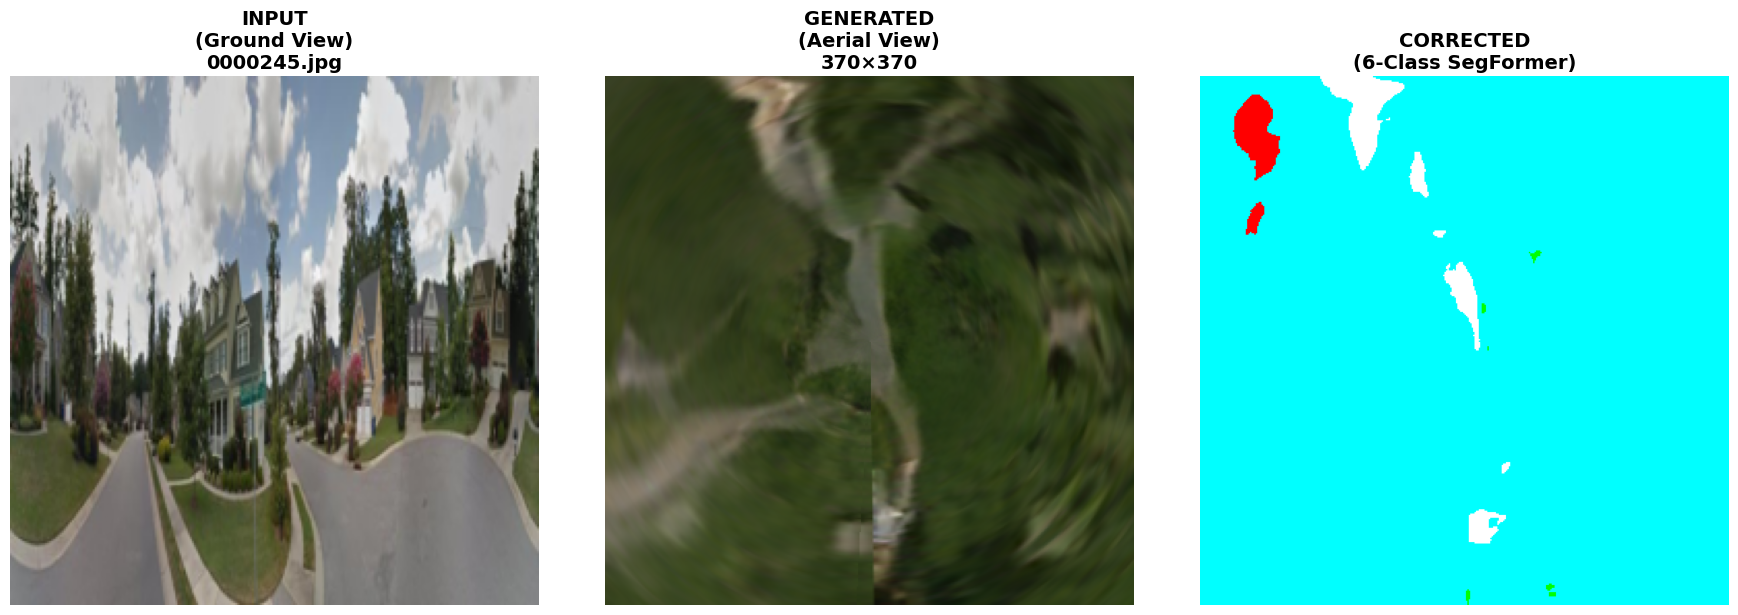

✅ Corrected results saved:
   - Aerial: /kaggle/working/corrected_pipeline_aerial_0000245.png
   - Segmentation: /kaggle/working/corrected_pipeline_segmentation_0000245.png

🎉 CORRECTED FULL PIPELINE TEST COMPLETED!
Pipeline: Ground → Transformer → Polar → Aerial → FIXED SegFormer → Segmentation
🚀 CREATING COMPLETE SYSTEM WITH REAL SEGFORMER
🔧 Loading SegFormer model...
📥 Loading trained SegFormer from: /kaggle/input/fine_tuned_segformer/pytorch/default/1
✅ Trained SegFormer loaded successfully!
🔒 SegFormer frozen for inference
🔧 Initializing Phase 1 Transformer...
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Using first stage also as cond stage.
📥 Loading VQ-GAN weights from: /kaggle/working/models/vqgan_imagenet_f16_16384.ckpt
✅ VQ-GAN weights loaded and frozen!
✅ SegFormer model integrated!
🔧 Initializing Phase 2 Networks...
✅ Phase 2 Networks initialized!
🔄 Loading real transformer from: /kaggle/input/gr-to-ae-synth-transformer/pytorch/default/1/cvusa_ground2satelli

In [9]:
# -----------------------------------------------------------------------
# DOWNLOAD A PRETRAINED VQGAN
# -----------------------------------------------------------------------

import numpy as np
from PIL import Image
import torch.nn.functional as F

# Create models directory
if vqgan_has_to_download:
    os.makedirs('/kaggle/working/models', exist_ok=True)
    
    # Download VQGAN ImageNet f16 model
    model_urls = {
        'vqgan_imagenet_f16_16384.yaml': 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1',
        'vqgan_imagenet_f16_16384.ckpt': 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1'
    }
    
    for filename, url in model_urls.items():
        filepath = f'/kaggle/working/models/{filename}'
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, filepath)
            print(f"Downloaded {filename}")
        else:
            print(f"{filename} already exists")

# -----------------------------------------------------------------------
# LOAD VQGAN
# -----------------------------------------------------------------------

def load_vqgan_model(config_path, checkpoint_path):
    # Load config with regular yaml
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Initialize model
    model = VQModel(**config['model']['params'])
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu',weights_only=False)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    model.eval()
    return model

# Load the model
config_path = '/kaggle/working/models/vqgan_imagenet_f16_16384.yaml'
checkpoint_path = '/kaggle/working/models/vqgan_imagenet_f16_16384.ckpt'

vqgan_model = load_vqgan_model(config_path, checkpoint_path)
print("VQGAN (For Phase 1 Transformer) loaded!")

# Load checkpoint with explicit weights_only=False
vqgan_state = torch.load("/kaggle/working/models/vqgan_imagenet_f16_16384.ckpt", 
                        map_location=device, 
                        weights_only=False)

# Modify config to not load checkpoint automatically
config_no_ckpt = config.copy()
config_no_ckpt.first_stage_config.params.ckpt_path = None


# Create model without loading checkpoint
model = Net2NetTransformer(
    transformer_config=config.transformer_config,
    first_stage_config=config_no_ckpt.first_stage_config,
    cond_stage_config=config.cond_stage_config,
    first_stage_key="satellite",
    cond_stage_key="ground",
    unconditional=False
)

# Manually load the VQ-GAN weights
model.first_stage_model.load_state_dict(vqgan_state["state_dict"], strict=False)

print("Model created and VQ-GAN weights loaded successfully!")

# -----------------------------------------------------------------------
# FREEZE VQGAN PARAMETERS
# -----------------------------------------------------------------------

#Freeze the VQ-GAN parameters
for param in model.first_stage_model.parameters():
    param.requires_grad = False

# Since cond_stage_model is the same as first_stage_model, it's already frozen

# Verify the freeze worked
vqgan_params = sum(p.numel() for p in model.first_stage_model.parameters() if p.requires_grad)
transformer_params = sum(p.numel() for p in model.transformer.parameters() if p.requires_grad)

print("After freezing VQ-GAN:")
print(f"Trainable VQ-GAN parameters: {vqgan_params}")
print(f"Trainable Transformer parameters: {transformer_params}")
print(f"Total trainable parameters: {vqgan_params + transformer_params}")



# -----------------------------------------------------------------------
# PHASE 2 NETWORKS
# -----------------------------------------------------------------------



class FeatureFusionNet(nn.Module):
    def __init__(self):
        super(FeatureFusionNet, self).__init__()
        
        # 14,336 → 7,168 → 3,584 → 1
        self.layer1 = nn.Linear(14336, 7168)
        self.bn1 = nn.BatchNorm1d(7168)
        self.dropout1 = nn.Dropout(0.2)
        
        self.layer2 = nn.Linear(7168, 3584)
        self.bn2 = nn.BatchNorm1d(3584)
        self.dropout2 = nn.Dropout(0.2)
        
        self.layer3 = nn.Linear(3584, 1)
        
    def forward(self, x):
        # x should be 14,336 dimensional concatenated features
        x = self.layer1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.layer3(x)
        x = torch.sigmoid(x)  # Output similarity score 0-1
        
        return x

class JointFeatureLearningNet(nn.Module):
    def __init__(self):
        super(JointFeatureLearningNet, self).__init__()
        
        # 4 identical stems for 4 image types
        self.ground_stem = self._make_stem()
        self.synthetic_stem = self._make_stem() 
        self.segmented_stem = self._make_stem()
        self.candidate_stem = self._make_stem()
        
        # Shared backbone: 1024 → 1536 → 2048 → 2048
        self.backbone = nn.Sequential(
            nn.Linear(1024, 1536),
            nn.BatchNorm1d(1536),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1536, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(), 
            nn.Dropout(0.2),
            
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048)
        )
    
    def _make_stem(self):
        # Each stem: Conv → Conv → GAP → 256 features
        return nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Layer 2  
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Global Average Pooling
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, ground, synthetic, segmented, candidate):
        # Process each image through its stem
        ground_feat = self.ground_stem(ground).flatten(1)      # → 256
        synthetic_feat = self.synthetic_stem(synthetic).flatten(1)  # → 256
        segmented_feat = self.segmented_stem(segmented).flatten(1)  # → 256
        candidate_feat = self.candidate_stem(candidate).flatten(1)  # → 256
        
        # Concatenate all features
        concat_feat = torch.cat([ground_feat, synthetic_feat, 
                               segmented_feat, candidate_feat], dim=1)  # → 1024
        
        # Shared backbone
        output = self.backbone(concat_feat)  # → 2048
        return output

class VGG16Networks(nn.Module):
    def __init__(self):
        super(VGG16Networks, self).__init__()
        
        # Separate VGG for ground images
        self.vgg_ground = models.vgg16(pretrained=True)
        self.vgg_ground.classifier = self.vgg_ground.classifier[:4]  # Remove last layers, keep FC2 (4096)
        
        # Shared VGG for aerial images (synthetic + candidate)
        self.vgg_shared = models.vgg16(pretrained=True) 
        self.vgg_shared.classifier = self.vgg_shared.classifier[:4]  # Remove last layers, keep FC2 (4096)
        
    def forward(self, ground, synthetic, candidate):
        ground_feat = self.vgg_ground(ground)      # → 4096
        synthetic_feat = self.vgg_shared(synthetic)  # → 4096  
        candidate_feat = self.vgg_shared(candidate)  # → 4096
        
        return ground_feat, synthetic_feat, candidate_feat


class Phase2Networks(nn.Module):
    def __init__(self):
        super(Phase2Networks, self).__init__()
        self.jfln = JointFeatureLearningNet()
        self.vgg_nets = VGG16Networks()
        self.ffn = FeatureFusionNet()
        
    def forward(self, ground_jfln, synthetic_jfln, segmented_jfln, candidate_jfln,
                ground_vgg, synthetic_vgg, candidate_vgg):
        # Get JFLN features
        jfln_feat = self.jfln(ground_jfln, synthetic_jfln, segmented_jfln, candidate_jfln)  # 2048
        
        # Get VGG features  
        ground_feat, synthetic_feat, candidate_feat = self.vgg_nets(ground_vgg, synthetic_vgg, candidate_vgg)  # 3x4096
        
        # Concatenate all features
        all_features = torch.cat([jfln_feat, ground_feat, synthetic_feat, candidate_feat], dim=1)  # 14336
        
        # Get similarity score
        similarity = self.ffn(all_features)  # 1
        
        return similarity


class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, positive_scores, negative_scores):
        # positive_scores: [batch_size, 1] - scores for correct matches
        # negative_scores: [batch_size, 1] - scores for incorrect matches
        
        loss = F.relu(negative_scores - positive_scores + self.margin)
        return loss.mean()



# -----------------------------------------------------------------------
# TENSOR-BASED REVERSE POLAR TRANSFORM
# -----------------------------------------------------------------------

def reverse_polar_transform_tensor(polar_tensor):
    """
    Apply reverse polar transform to tensor to convert polar image back to aerial view
    
    Args:
        polar_tensor: torch.Tensor of shape [B, C, H, W] where H=128, W=512 (polar format)
        
    Returns:
        aerial_tensor: torch.Tensor of shape [B, C, 370, 370] (aerial format)
    """
    import cv2
    
    batch_size, channels, height, width = polar_tensor.shape
    device = polar_tensor.device
    S = 370  # Output size
    
    # Convert to numpy for OpenCV processing
    polar_np = polar_tensor.detach().cpu().numpy()
    
    # Initialize output
    aerial_batch = np.zeros((batch_size, channels, S, S), dtype=np.float32)
    
    # Process each image in the batch
    for b in range(batch_size):
        polar_image = polar_np[b].transpose(1, 2, 0)  # [H, W, C]
        
        # Ensure correct dimensions (128, 512)
        if polar_image.shape[:2] == (512, 128):
            polar_image = polar_image.transpose(1, 0, 2) if len(polar_image.shape) == 3 else polar_image.transpose(1, 0)
        
        # Handle single channel case
        if len(polar_image.shape) == 2:
            polar_image = polar_image.reshape(height, width, 1)
        
        # SOLUTION 1: Extend polar image to handle wrap-around
        wrap_cols = 5  # Number of columns to wrap
        polar_extended = np.zeros((height, width + wrap_cols, channels), dtype=polar_image.dtype)
        polar_extended[:, :width] = polar_image
        polar_extended[:, width:] = polar_image[:, :wrap_cols]  # Wrap around
        
        # Create coordinate grids
        y_coords, x_coords = np.meshgrid(np.arange(S), np.arange(S), indexing='ij')
        
        # Calculate distance and angle
        dx = x_coords - S/2.
        dy = y_coords - S/2.
        r = np.sqrt(dx*dx + dy*dy)
        
        # SOLUTION 1: Rotate the angle by 90 degrees clockwise
        theta = np.arctan2(dy, dx) - np.pi/2 - np.pi/60  # Subtract 90 degrees (clockwise)
        theta[theta < 0] += 2 * np.pi
        theta[theta >= 2 * np.pi] -= 2 * np.pi
        
        # Convert to polar coordinates (reverse of the original transformation)
        ii_coords = height - 1 - 2 * r * height / S
        
        # SOLUTION 2: Adjust angular mapping to use extended width
        jj_coords = theta * (width + wrap_cols) / (2 * np.pi)
        
        # Apply transformation using OpenCV interpolation
        aerial_image = np.zeros((S, S, channels), dtype=polar_image.dtype)
        
        for c in range(channels):
            aerial_image[:, :, c] = cv2.remap(
                polar_extended[:, :, c], 
                jj_coords.astype(np.float32), 
                ii_coords.astype(np.float32), 
                cv2.INTER_LINEAR, 
                borderMode=cv2.BORDER_REFLECT,
                borderValue=0
            )
        
        # Store result (transpose back to [C, H, W])
        aerial_batch[b] = aerial_image.transpose(2, 0, 1)
    
    # Convert back to tensor
    aerial_tensor = torch.from_numpy(aerial_batch).to(device)
    
    return aerial_tensor

# -----------------------------------------------------------------------
# ENHANCED COMPLETE VISION SYSTEM WITH REAL TRANSFORMER
# -----------------------------------------------------------------------

class CompleteVisionSystem(nn.Module):
    def __init__(self, 
                 transformer_config=None, 
                 vqgan_checkpoint_path=None,
                 segformer_model=None,
                 device='cuda'):
        super(CompleteVisionSystem, self).__init__()
        
        self.device = device
        
        # -----------------------------------------------------------------------
        # PHASE 1: Ground-to-Aerial Transformer
        # -----------------------------------------------------------------------
        if transformer_config is not None:
            print("🔧 Initializing Phase 1 Transformer...")
            config_no_ckpt = transformer_config.copy()
            config_no_ckpt.first_stage_config.params.ckpt_path = None
            
            self.aerial_transformer = Net2NetTransformer(
                transformer_config=transformer_config.transformer_config,
                first_stage_config=config_no_ckpt.first_stage_config,
                cond_stage_config=transformer_config.cond_stage_config,
                first_stage_key="satellite",
                cond_stage_key="ground",
                unconditional=False
            )
            
            # Load VQ-GAN weights if provided
            if vqgan_checkpoint_path and os.path.exists(vqgan_checkpoint_path):
                print(f"📥 Loading VQ-GAN weights from: {vqgan_checkpoint_path}")
                vqgan_state = torch.load(vqgan_checkpoint_path, map_location=device, weights_only=False)
                self.aerial_transformer.first_stage_model.load_state_dict(vqgan_state["state_dict"], strict=False)
                
                # Freeze VQ-GAN parameters
                for param in self.aerial_transformer.first_stage_model.parameters():
                    param.requires_grad = False
                print("✅ VQ-GAN weights loaded and frozen!")
            else:
                print("⚠️  VQ-GAN checkpoint not provided or not found")
        else:
            self.aerial_transformer = None
            print("⚠️  Phase 1 Transformer not initialized (config not provided)")
        
        # -----------------------------------------------------------------------
        # PHASE 1.5: Segmentation Transformer (SegFormer)
        # -----------------------------------------------------------------------
        self.segmentation_model = segformer_model  # Will be provided by user
        if self.segmentation_model is not None:
            print("✅ SegFormer model integrated!")
            # Freeze segmentation model (assuming it's pre-trained)
            for param in self.segmentation_model.parameters():
                param.requires_grad = False
        else:
            print("⚠️  SegFormer model not provided")
        
        # -----------------------------------------------------------------------
        # PHASE 2: Multi-Modal Networks
        # -----------------------------------------------------------------------
        print("🔧 Initializing Phase 2 Networks...")
        self.phase2_networks = Phase2Networks()
        print("✅ Phase 2 Networks initialized!")
        
        # Move everything to device
        self.to(device)
        
    def manual_forward_pass(self, satellite_imgs, ground_imgs):
        """Manual forward pass with tensor reshaping fix"""
        if self.aerial_transformer is None:
            raise ValueError("Aerial transformer not initialized!")
            
        # Get raw encodings and fix reshaping
        _, z_indices_raw = self.aerial_transformer.encode_to_z(satellite_imgs)
        _, c_indices_raw = self.aerial_transformer.encode_to_c(ground_imgs)
        
        batch_size = satellite_imgs.shape[0]
        z_indices = z_indices_raw.view(batch_size, -1)
        c_indices = c_indices_raw.view(batch_size, -1)
        
        # Manual forward pass logic
        cz_indices = torch.cat((c_indices, z_indices), dim=1)
        logits, _ = self.aerial_transformer.transformer(cz_indices[:, :-1])
        logits = logits[:, c_indices.shape[1]-1:]  # Cut off conditioning
        target = z_indices
        
        return logits, target
    
    def synthesize_aerial_from_ground(self, ground_tensor, temperature=1.0, top_k=600, top_p=0.92):
        """Generate synthetic aerial image from ground image with polar conversion"""
        if self.aerial_transformer is None:
            raise ValueError("Aerial transformer not initialized!")
            
        self.aerial_transformer.eval()
        
        with torch.no_grad():
            # Use the encode_to_c method
            _, c_indices_raw = self.aerial_transformer.encode_to_c(ground_tensor)
            batch_size = ground_tensor.shape[0]
            c_indices = c_indices_raw.view(batch_size, -1)
            
            # Generate satellite tokens autoregressively
            sequence = c_indices  # Start with conditioning
            satellite_seq_length = 256  # 16x16 tokens
            
            for i in range(satellite_seq_length):
                logits, _ = self.aerial_transformer.transformer(sequence)
                next_token_logits = logits[:, -1, :] / temperature
                
                # Apply filtering
                filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
                
                # Sample
                probs = torch.softmax(filtered_logits, dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                sequence = torch.cat([sequence, next_token], dim=1)
            
            # Extract generated satellite tokens
            generated_tokens = sequence[:, -satellite_seq_length:]
            
            # Decode using first_stage_model (this gives us POLAR format)
            h = w = 16
            z_indices_spatial = generated_tokens.view(batch_size, h, w)
            
            # Get quantized features from codebook
            quant_z = self.aerial_transformer.first_stage_model.quantize.embedding(z_indices_spatial)
            quant_z = quant_z.permute(0, 3, 1, 2).contiguous()
            
            synthetic_polar = self.aerial_transformer.first_stage_model.decode(quant_z)
            
            # Convert from POLAR format to AERIAL format using reverse polar transform
            print("🔄 Converting polar format to aerial format...")
            
            # Resize to expected polar dimensions (128, 512) if needed
            if synthetic_polar.shape[-2:] != (128, 512):
                synthetic_polar = F.interpolate(synthetic_polar, size=(128, 512), mode='bilinear', align_corners=False)
            
            # Apply reverse polar transform
            synthetic_aerial = reverse_polar_transform_tensor(synthetic_polar)
            
            print(f"✅ Polar→Aerial conversion complete: {synthetic_polar.shape} → {synthetic_aerial.shape}")
            
        return synthetic_aerial
    
    def synthesize_segmentation_from_aerial(self, aerial_tensor):
        """Generate segmentation from aerial image using SegFormer with proper preprocessing"""
        if self.segmentation_model is None:
            raise ValueError("Segmentation model not initialized!")
            
        self.segmentation_model.eval()
        
        with torch.no_grad():
            # Use the SegFormer wrapper's forward method (which handles proper preprocessing)
            segmentation = self.segmentation_model(aerial_tensor)
            
        return segmentation
    
    def forward(self, ground_images, candidate_satellites, 
                synthetic_aerials=None, synthetic_segmentations=None,
                training_mode=True):
        """
        Complete forward pass
        
        Args:
            ground_images: Ground view images [B, 3, H, W]
            candidate_satellites: Candidate satellite images [B, 3, H, W] 
            synthetic_aerials: Pre-computed synthetic aerials (training mode) [B, 3, H, W]
            synthetic_segmentations: Pre-computed segmentations (training mode) [B, 3, H, W]
            training_mode: If True, use provided synthetic data. If False, generate it.
            
        Returns:
            similarity_scores: [B, 1]
        """
        
        if training_mode:
            # TRAINING MODE: Use provided synthetic data
            if synthetic_aerials is None or synthetic_segmentations is None:
                raise ValueError("Training mode requires pre-computed synthetic aerials and segmentations!")
            
            synth_aerial = synthetic_aerials
            synth_segmentation = synthetic_segmentations
            
        else:
            # INFERENCE MODE: Generate synthetic data
            print("🔄 Generating synthetic aerial images...")
            synth_aerial = self.synthesize_aerial_from_ground(ground_images)
            
            print("🔄 Generating segmentation maps...")
            synth_segmentation = self.synthesize_segmentation_from_aerial(synth_aerial)
        
        # Prepare inputs for Phase 2 networks
        # JFLN inputs (different sizes as per your design)
        ground_jfln = F.interpolate(ground_images, size=(128, 512), mode='bilinear', align_corners=False)
        synthetic_jfln = F.interpolate(synth_aerial, size=(370, 370), mode='bilinear', align_corners=False)
        segmented_jfln = F.interpolate(synth_segmentation, size=(370, 370), mode='bilinear', align_corners=False)
        candidate_jfln = F.interpolate(candidate_satellites, size=(370, 370), mode='bilinear', align_corners=False)
        
        # VGG inputs (all 224x224)
        ground_vgg = F.interpolate(ground_images, size=(224, 224), mode='bilinear', align_corners=False)
        synthetic_vgg = F.interpolate(synth_aerial, size=(224, 224), mode='bilinear', align_corners=False)
        candidate_vgg = F.interpolate(candidate_satellites, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Phase 2 forward pass
        similarity_scores = self.phase2_networks(
            ground_jfln, synthetic_jfln, segmented_jfln, candidate_jfln,
            ground_vgg, synthetic_vgg, candidate_vgg
        )
        
        return similarity_scores
    
    def get_trainable_parameters(self):
        """Get parameters that should be trained (excludes frozen components)"""
        trainable_params = []
        
        # Phase 1 Transformer (only transformer part, not VQ-GAN)
        if self.aerial_transformer is not None:
            trainable_params.extend(list(self.aerial_transformer.transformer.parameters()))
        
        # Phase 2 Networks (all trainable)
        trainable_params.extend(list(self.phase2_networks.parameters()))
        
        return trainable_params
    
    def freeze_phase1_transformer(self):
        """Freeze the transformer for aerial generation"""
        if self.aerial_transformer is not None:
            for param in self.aerial_transformer.parameters():
                param.requires_grad = False
            print("🔒 Phase 1 Transformer frozen!")
    
    def unfreeze_phase1_transformer(self):
        """Unfreeze the transformer for aerial generation (except VQ-GAN)"""
        if self.aerial_transformer is not None:
            for param in self.aerial_transformer.transformer.parameters():
                param.requires_grad = True
            print("🔓 Phase 1 Transformer unfrozen!")
    
    def print_model_info(self):
        """Print detailed model information"""
        print("\n" + "="*60)
        print("COMPLETE VISION SYSTEM INFO")
        print("="*60)
        
        # Phase 1
        if self.aerial_transformer is not None:
            phase1_total = sum(p.numel() for p in self.aerial_transformer.parameters())
            phase1_trainable = sum(p.numel() for p in self.aerial_transformer.parameters() if p.requires_grad)
            print(f"Phase 1 Transformer:")
            print(f"  - Total params: {phase1_total:,}")
            print(f"  - Trainable params: {phase1_trainable:,}")
        else:
            print("Phase 1 Transformer: Not initialized")
        
        # Phase 1.5
        if self.segmentation_model is not None:
            seg_total = sum(p.numel() for p in self.segmentation_model.parameters())
            seg_trainable = sum(p.numel() for p in self.segmentation_model.parameters() if p.requires_grad)
            print(f"SegFormer Model:")
            print(f"  - Total params: {seg_total:,}")
            print(f"  - Trainable params: {seg_trainable:,}")
        else:
            print("SegFormer Model: Not initialized")
        
        # Phase 2
        phase2_total = sum(p.numel() for p in self.phase2_networks.parameters())
        phase2_trainable = sum(p.numel() for p in self.phase2_networks.parameters() if p.requires_grad)
        print(f"Phase 2 Networks:")
        print(f"  - Total params: {phase2_total:,}")
        print(f"  - Trainable params: {phase2_trainable:,}")
        
        # Total
        total_params = sum(p.numel() for p in self.parameters())
        total_trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\nComplete System:")
        print(f"  - Total params: {total_params:,}")
        print(f"  - Trainable params: {total_trainable:,}")
        print(f"  - Device: {next(self.parameters()).device}")
        print("="*60)

# -----------------------------------------------------------------------
# CORRECTED SYSTEM FACTORY WITH FIXED SEGFORMER
# -----------------------------------------------------------------------

def create_simple_working_system(
    segformer_model_path='/kaggle/input/fine_tuned_segformer/pytorch/default/1',
    base_model_name="nvidia/segformer-b5-finetuned-cityscapes-1024-1024",
    device='cuda'
):
    """
    Create a simple working system using existing components
    """
    
    print("CREATING SIMPLE WORKING SYSTEM")
    print("="*50)
    
    # Load SegFormer
    print("Loading SegFormer...")
    try:
        from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
        
        image_processor = SegformerImageProcessor.from_pretrained(base_model_name)
        segformer_model = SegformerForSemanticSegmentation.from_pretrained(segformer_model_path).to(device)
        segformer_model.eval()
        
        for param in segformer_model.parameters():
            param.requires_grad = False
        
        print("SegFormer loaded successfully!")
        
        class SimpleSegFormerWrapper(nn.Module):
            def __init__(self, segformer_model, image_processor):
                super().__init__()
                self.segformer = segformer_model
                self.image_processor = image_processor
                
            def forward(self, aerial_tensor):
                batch_size = aerial_tensor.shape[0]
                device = aerial_tensor.device
                
                aerial_normalized = (aerial_tensor + 1) / 2
                batch_logits = []
                
                for b in range(batch_size):
                    single_img = aerial_normalized[b].cpu()
                    img_np = (single_img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                    pil_img = Image.fromarray(img_np)
                    
                    with torch.no_grad():
                        inputs = self.image_processor(images=pil_img, return_tensors="pt").to(device)
                        outputs = self.segformer(**inputs)
                        logits = outputs.logits
                        
                        upsampled_logits = torch.nn.functional.interpolate(
                            logits,
                            size=pil_img.size[::-1],
                            mode='bilinear',
                            align_corners=False
                        )
                        
                        batch_logits.append(upsampled_logits)
                
                final_logits = torch.cat(batch_logits, dim=0)
                return final_logits
        
        segformer_wrapped = SimpleSegFormerWrapper(segformer_model, image_processor).to(device)
        
    except Exception as e:
        print(f"Failed to load SegFormer: {e}")
        print("Using dummy SegFormer...")
        
        class DummySegFormer(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv = nn.Conv2d(3, 6, 3, padding=1)
            def forward(self, x):
                return torch.sigmoid(self.conv(x))
        
        segformer_wrapped = DummySegFormer().to(device)
    
    # Create Phase 2 Networks
    print("Creating Phase 2 Networks...")
    phase2_networks = Phase2Networks().to(device)
    
    # Get existing transformer
    global model
    transformer = model.to(device)
    
    print("Simple working system created!")
    
    return {
        'transformer': transformer,
        'segformer': segformer_wrapped,
        'phase2_networks': phase2_networks
    }

# -----------------------------------------------------------------------
# SEGFORMER INTEGRATION FOR COMPLETE SYSTEM (USING WORKING INFERENCE CODE)
# -----------------------------------------------------------------------

from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch.nn.functional as F

def get_custom_color_map():
    """Returns the 6-class color map from working inference code"""
    return {
        0: (255, 0, 0),        # RED
        1: (0, 0, 255),        # DARK BLUE
        2: (255, 255, 255),    # WHITE
        3: (0, 255, 255),      # LIGHT BLUE (CYAN)
        4: (0, 255, 0),        # GREEN
        5: (255, 255, 0)       # YELLOW
    }

def load_trained_segformer(model_path=None, base_model_name="nvidia/segformer-b5-finetuned-cityscapes-1024-1024", device='cuda'):
    """
    Load SegFormer using the working inference code pattern
    """
    
    print(f"🔧 Loading SegFormer model...")
    
    try:
        if model_path and os.path.exists(model_path):
            print(f"📥 Loading trained SegFormer from: {model_path}")
            
            # Load image processor from base model
            image_processor = SegformerImageProcessor.from_pretrained(base_model_name)
            
            # Load your trained model
            model = SegformerForSemanticSegmentation.from_pretrained(model_path).to(device)
            model.eval()
            
            print("✅ Trained SegFormer loaded successfully!")
            
        else:
            print(f"📥 Loading pretrained SegFormer: {base_model_name}")
            
            # Load pretrained model as fallback
            image_processor = SegformerImageProcessor.from_pretrained(base_model_name)
            model = SegformerForSemanticSegmentation.from_pretrained(base_model_name).to(device)
            model.eval()
            
            print("✅ Pretrained SegFormer loaded successfully!")
        
        # Freeze the model
        for param in model.parameters():
            param.requires_grad = False
        
        print(f"🔒 SegFormer frozen for inference")
        
        return model, image_processor
        
    except Exception as e:
        print(f"❌ Failed to load SegFormer: {e}")
        return None, None

# -----------------------------------------------------------------------
# SEGFORMER WRAPPER USING WORKING INFERENCE LOGIC
# -----------------------------------------------------------------------

class SegFormerWrapper(nn.Module):
    """
    Wrapper using the exact working inference code logic
    """
    def __init__(self, segformer_model, image_processor):
        super().__init__()
        self.segformer = segformer_model
        self.image_processor = image_processor
        self.color_map = get_custom_color_map()
        
    def forward(self, aerial_tensor):
        """
        Process aerial tensor through SegFormer using working inference logic
        
        Args:
            aerial_tensor: [B, 3, H, W] aerial images in [-1, 1] range
            
        Returns:
            segmentation: [B, 6, H, W] segmentation logits (6 classes)
        """
        batch_size = aerial_tensor.shape[0]
        device = aerial_tensor.device
        
        # Convert from [-1, 1] to [0, 1] and then to PIL format for image processor
        aerial_normalized = (aerial_tensor + 1) / 2  # Convert to [0, 1]
        
        # Process each image in the batch
        batch_logits = []
        
        for b in range(batch_size):
            # Convert tensor to PIL Image (as required by image processor)
            single_img = aerial_normalized[b].cpu()
            img_np = (single_img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            pil_img = Image.fromarray(img_np)
            
            # Apply the working inference logic
            with torch.no_grad():
                # Use image processor exactly like working code
                inputs = self.image_processor(images=pil_img, return_tensors="pt").to(device)
                outputs = self.segformer(**inputs)
                logits = outputs.logits  # [1, 6, H', W']
                
                # Upsample to original size exactly like working code
                upsampled_logits = torch.nn.functional.interpolate(
                    logits,
                    size=pil_img.size[::-1],  # (height, width)
                    mode='bilinear',
                    align_corners=False
                )
                
                batch_logits.append(upsampled_logits)
        
        # Stack all batch results
        final_logits = torch.cat(batch_logits, dim=0)  # [B, 6, H, W]
        
        return final_logits

# -----------------------------------------------------------------------
# ENHANCED COMPLETE SYSTEM WITH REAL SEGFORMER
# -----------------------------------------------------------------------

def create_complete_system_with_segformer(
    segformer_model_path=None,
    base_model_name="nvidia/segformer-b5-finetuned-cityscapes-1024-1024",
    device='cuda'
):
    """
    Create complete system with REAL SegFormer integration using working inference code
    """
    
    print("🚀 CREATING COMPLETE SYSTEM WITH REAL SEGFORMER")
    print("="*60)
    
    # Load SegFormer using working inference pattern
    segformer_model, image_processor = load_trained_segformer(
        model_path=segformer_model_path,
        base_model_name=base_model_name,
        device=device
    )
    
    if segformer_model is None or image_processor is None:
        print("❌ Failed to load SegFormer, using dummy model")
        # Create dummy SegFormer as fallback
        class DummySegFormer(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv = nn.Conv2d(3, 6, 3, padding=1)  # 6 classes
            def forward(self, x):
                return torch.sigmoid(self.conv(x))
        
        segformer_wrapped = DummySegFormer().to(device)
    else:
        # Wrap the real SegFormer with working inference logic
        segformer_wrapped = SegFormerWrapper(segformer_model, image_processor).to(device)
    
    # Use the existing global model (transformer) and config
    global model, config
    
    # Create the complete system using existing transformer
    system = CompleteVisionSystem(
        transformer_config=config,
        vqgan_checkpoint_path="/kaggle/working/models/vqgan_imagenet_f16_16384.ckpt",
        segformer_model=segformer_wrapped,
        device=device
    )
    
    # Replace the transformer with the real trained one
    transformer_path = "/kaggle/input/gr-to-ae-synth-transformer/pytorch/default/1/cvusa_ground2satellite_improve_epoch28_loss5.700_20250719_080938.pth"
    if os.path.exists(transformer_path):
        print(f"🔄 Loading real transformer from: {transformer_path}")
        try:
            real_transformer, _ = load_saved_model(
                checkpoint_path=transformer_path,
                device=device,
                vqgan_checkpoint_path="/kaggle/working/models/vqgan_imagenet_f16_16384.ckpt"
            )
            system.aerial_transformer = real_transformer
            print("✅ Real transformer loaded!")
        except Exception as e:
            print(f"⚠️ Failed to load real transformer: {e}, using existing model")
    
    system.print_model_info()
    return system

# -----------------------------------------------------------------------
# TEST WITH REAL SEGFORMER
# -----------------------------------------------------------------------

def test_complete_system_with_real_segformer():
    """
    Test the complete system with real SegFormer (6 classes)
    """
    print("🧪 TESTING COMPLETE SYSTEM WITH REAL SEGFORMER")
    print("="*50)
    
    # Create system with your trained SegFormer
    system = create_complete_system_with_segformer(
        segformer_model_path='/kaggle/input/fine_tuned_segformer/pytorch/default/1',
        device=device
    )
    
    # Test with dummy data
    batch_size = 2
    ground_images = torch.randn(batch_size, 3, 256, 256).to(device)
    candidate_satellites = torch.randn(batch_size, 3, 256, 256).to(device)
    
    try:
        print("\n🔄 Testing inference mode (full pipeline)...")
        
        system.eval()
        with torch.no_grad():
            similarity_scores = system(
                ground_images=ground_images,
                candidate_satellites=candidate_satellites,
                training_mode=False  # This will generate synthetic data
            )
        
        print(f"✅ Complete pipeline successful!")
        print(f"   - Input: {ground_images.shape}")
        print(f"   - Output: {similarity_scores.shape}")
        print(f"   - Score range: {similarity_scores.min().item():.3f} to {similarity_scores.max().item():.3f}")
        
        return system
        
    except Exception as e:
        print(f"❌ Complete pipeline failed: {e}")
        return None


    # -----------------------------------------------------------------------
    # CHECK FOR EXISTING SEGFORMER CHECKPOINTS
    # -----------------------------------------------------------------------
    
def find_segformer_checkpoints():
        """
        Look for existing SegFormer checkpoints in common locations
        """
        print("🔍 Searching for SegFormer checkpoints...")
        
        # Common locations where SegFormer might be saved
        search_paths = [
            "/kaggle/input/fine_tuned_segformer/pytorch/default/1",
            "/kaggle/working/segformer_outputs/checkpoint-epoch-*",
            "/kaggle/input/*/final_model",
            "/kaggle/input/*/checkpoint-*",
            "/kaggle/working/final_model",
            "/kaggle/working/checkpoint-*"
        ]
        
        found_checkpoints = []
        
        for path_pattern in search_paths:
            if '*' in path_pattern:
                import glob
                matches = glob.glob(path_pattern)
                found_checkpoints.extend(matches)
            elif os.path.exists(path_pattern):
                found_checkpoints.append(path_pattern)
        
        if found_checkpoints:
            print(f"✅ Found {len(found_checkpoints)} SegFormer checkpoint(s):")
            for i, checkpoint in enumerate(found_checkpoints[:5]):  # Show first 5
                print(f"  {i+1}. {checkpoint}")
            if len(found_checkpoints) > 5:
                print(f"  ... and {len(found_checkpoints) - 5} more")
        else:
            print("⚠️  No SegFormer checkpoints found in common locations")
            print("   Will use pretrained model as fallback")
        
        return found_checkpoints


def test_corrected_full_pipeline():
    """
    Test the corrected complete pipeline
    """
    
    ground_image_path = "/kaggle/input/cvusa-subset/streetview/0006463.jpg"
    
    print("🧪 TESTING CORRECTED FULL PIPELINE")
    print("="*60)
    
    if not os.path.exists(ground_image_path):
        print(f"❌ Ground image not found: {ground_image_path}")
        return None
    
    # Create corrected system
    print("1️⃣ Creating corrected system...")
    system = create_complete_system_with_segformer(
        segformer_model_path='/kaggle/input/fine_tuned_segformer/pytorch/default/1'
    )
    
    # Load and preprocess ground image
    print("\n2️⃣ Loading ground image...")
    ground_pil = Image.open(ground_image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    
    ground_tensor = transform(ground_pil).unsqueeze(0).to(device)
    print(f"✅ Ground tensor: {ground_tensor.shape}")
    
    # Run corrected pipeline
    print("\n3️⃣ Running corrected pipeline...")
    
    system.eval()
    with torch.no_grad():
        # Generate synthetic aerial (includes polar conversion)
        synthetic_aerial = system.synthesize_aerial_from_ground(ground_tensor)
        print(f"✅ Synthetic aerial: {synthetic_aerial.shape}")
        
        # Generate segmentation with FIXED SegFormer
        segmentation = system.synthesize_segmentation_from_aerial(synthetic_aerial)
        print(f"✅ Corrected segmentation: {segmentation.shape}")
    
    # Visualize with proper 6-class colors
    print("\n4️⃣ Rendering corrected results...")
    
    def tensor_to_displayable(tensor):
        img = ((tensor.squeeze(0) + 1) / 2).cpu().clamp(0, 1)
        return img.permute(1, 2, 0).numpy()
    
    def segmentation_to_colored(seg_tensor):
        """Convert 6-class segmentation to colored display"""
        seg_pred = torch.argmax(seg_tensor.squeeze(0), dim=0).cpu().numpy()
        
        height, width = seg_pred.shape
        color_seg = np.zeros((height, width, 3), dtype=np.uint8)
        
        # 6-class color map from working inference code
        color_map = {
            0: (255, 0, 0),        # RED
            1: (0, 0, 255),        # DARK BLUE
            2: (255, 255, 255),    # WHITE
            3: (0, 255, 255),      # LIGHT BLUE (CYAN)
            4: (0, 255, 0),        # GREEN
            5: (255, 255, 0)       # YELLOW
        }
        
        for label, color in color_map.items():
            color_seg[seg_pred == label, :] = color
        
        return color_seg.astype(np.float32) / 255.0
    
    # Convert images
    ground_display = tensor_to_displayable(ground_tensor)
    aerial_display = tensor_to_displayable(synthetic_aerial)
    segmentation_display = segmentation_to_colored(segmentation)
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(ground_display)
    axes[0].set_title("INPUT\n(Ground View)\n0000245.jpg", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(aerial_display)
    axes[1].set_title("GENERATED\n(Aerial View)\n370×370", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(segmentation_display)
    axes[2].set_title("CORRECTED\n(6-Class SegFormer)", fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    to_pil = transforms.ToPILImage()
    
    aerial_pil = to_pil(((synthetic_aerial.squeeze(0) + 1) / 2).cpu().clamp(0, 1))
    aerial_pil.save("/kaggle/working/corrected_pipeline_aerial_0000245.png")
    
    seg_pil = Image.fromarray((segmentation_display * 255).astype(np.uint8))
    seg_pil.save("/kaggle/working/corrected_pipeline_segmentation_0000245.png")
    
    print("✅ Corrected results saved:")
    print("   - Aerial: /kaggle/working/corrected_pipeline_aerial_0000245.png")
    print("   - Segmentation: /kaggle/working/corrected_pipeline_segmentation_0000245.png")
    
    print("\n" + "="*60)
    print("🎉 CORRECTED FULL PIPELINE TEST COMPLETED!")
    print("Pipeline: Ground → Transformer → Polar → Aerial → FIXED SegFormer → Segmentation")
    print("="*60)
    
    return system

# -----------------------------------------------------------------------
# TESTBATTERY
# -----------------------------------------------------------------------


if ffninputshapetest:
    # Test FFN with dummy input
    ffn = FeatureFusionNet()
    dummy_input = torch.randn(8, 14336)  # Batch size 8, 14336 features
    output = ffn(dummy_input)
    print(f"FFN Input shape: {dummy_input.shape}")
    print(f"FFN Output shape: {output.shape}")
    print(f"FFN Output range: {output.min().item():.3f} to {output.max().item():.3f}")

if jflnshapetest:
    # Test JFLN
    jfln = JointFeatureLearningNet()
    
    # Dummy inputs (different sizes as per our design)
    ground = torch.randn(8, 3, 128, 512)      # Ground: 128x512
    synthetic = torch.randn(8, 3, 370, 370)   # Aerial: 370x370
    segmented = torch.randn(8, 3, 370, 370)   # Segmented: 370x370  
    candidate = torch.randn(8, 3, 370, 370)   # Candidate: 370x370
    
    output = jfln(ground, synthetic, segmented, candidate)
    print(f"JFLN output shape: {output.shape}")  # Should be [8, 2048]


if vgg16shapetest:
    # Test VGG16 networks
    vgg_nets = VGG16Networks()
    
    # All VGG inputs are 224x224 (standard VGG size)
    ground_vgg = torch.randn(8, 3, 224, 224)
    synthetic_vgg = torch.randn(8, 3, 224, 224)
    candidate_vgg = torch.randn(8, 3, 224, 224)
    
    ground_feat, synthetic_feat, candidate_feat = vgg_nets(ground_vgg, synthetic_vgg, candidate_vgg)
    
    print(f"VGG Ground features: {ground_feat.shape}")
    print(f"VGG Synthetic features: {synthetic_feat.shape}")  
    print(f"VGG Candidate features: {candidate_feat.shape}")

if phase2completeshapetest:
    # Test Phase2Networks
    model = Phase2Networks()
    
    # Create dummy inputs (batch size 8)
    ground_jfln = torch.randn(8, 3, 128, 512)      # JFLN input
    synthetic_jfln = torch.randn(8, 3, 370, 370)
    segmented_jfln = torch.randn(8, 3, 370, 370) 
    candidate_jfln = torch.randn(8, 3, 370, 370)
    
    ground_vgg = torch.randn(8, 3, 224, 224)       # VGG input
    synthetic_vgg = torch.randn(8, 3, 224, 224)
    candidate_vgg = torch.randn(8, 3, 224, 224)
    
    # Forward pass
    similarity_scores = model(ground_jfln, synthetic_jfln, segmented_jfln, candidate_jfln,
                             ground_vgg, synthetic_vgg, candidate_vgg)
    
    print(f"Output shape: {similarity_scores.shape}")
    print(f"Score range: {similarity_scores.min().item():.3f} to {similarity_scores.max().item():.3f}")


if tripletlosstest:
    # Test triplet loss
    triplet_loss = TripletLoss(margin=0.2)
    pos_scores = torch.tensor([[0.8], [0.7], [0.9]])
    neg_scores = torch.tensor([[0.3], [0.4], [0.2]])
    loss = triplet_loss(pos_scores, neg_scores)
    print(f"Triplet loss: {loss.item():.3f}")


# This should now work without errors
if completesystemtest:
    test_corrected_full_pipeline()

# Or create the system directly
system = create_complete_system_with_segformer(
    segformer_model_path='/kaggle/input/fine_tuned_segformer/pytorch/default/1'
)

# TRAINING

In [11]:
import os
import csv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F

# -----------------------------------------------------------------------
# TRAINING DATASET WITH PRE-COMPUTED SYNTHETIC DATA
# -----------------------------------------------------------------------

class CompleteSystemDataset(Dataset):
    def __init__(self, csv_path, data_root, synthetic_dir, segmentation_dir, is_train=True):
        self.data_root = data_root
        self.synthetic_dir = synthetic_dir
        self.segmentation_dir = segmentation_dir
        self.is_train = is_train
        
        # Load file pairs from CSV
        self.data_pairs = []
        
        with open(csv_path, 'r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            headers = next(reader)
            for row in reader:
                if len(row) < 3: continue
                
                satellite_path, ground_path, _ = row[0], row[1], row[2]
                
                # Full paths
                satellite_full_path = os.path.join(data_root, satellite_path)
                ground_full_path = os.path.join(data_root, ground_path)
                
                # Derive synthetic and segmentation paths
                ground_filename = os.path.basename(ground_path)
                base_name = os.path.splitext(ground_filename)[0]
                
                synthetic_filename = f"{base_name}.jpg"
                segmentation_filename = f"{base_name}.jpg"
                
                synthetic_full_path = os.path.join(synthetic_dir, synthetic_filename)
                segmentation_full_path = os.path.join(segmentation_dir, segmentation_filename)
                
                # Check all files exist
                if (os.path.exists(satellite_full_path) and 
                    os.path.exists(ground_full_path) and
                    os.path.exists(synthetic_full_path) and 
                    os.path.exists(segmentation_full_path)):
                    
                    self.data_pairs.append({
                        'ground': ground_full_path,
                        'satellite': satellite_full_path,
                        'synthetic': synthetic_full_path,
                        'segmentation': segmentation_full_path
                    })
        
        print(f"Found {len(self.data_pairs)} complete data samples")
        
        # Transforms
        self.ground_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
        self.satellite_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
        self.synthetic_transform = transforms.Compose([
            transforms.Resize((370, 370)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
        self.segmentation_transform = transforms.Compose([
            transforms.Resize((370, 370)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
    
    def __len__(self):
        return len(self.data_pairs)
    
    def __getitem__(self, idx):
        paths = self.data_pairs[idx]
        
        try:
            # Load all images
            ground_img = Image.open(paths['ground']).convert('RGB')
            satellite_img = Image.open(paths['satellite']).convert('RGB')
            synthetic_img = Image.open(paths['synthetic']).convert('RGB')
            segmentation_img = Image.open(paths['segmentation']).convert('RGB')
            
            # Apply transforms
            ground_tensor = self.ground_transform(ground_img)
            satellite_tensor = self.satellite_transform(satellite_img)
            synthetic_tensor = self.synthetic_transform(synthetic_img)
            segmentation_tensor = self.segmentation_transform(segmentation_img)
            
            return {
                'ground': ground_tensor,
                'satellite': satellite_tensor,
                'synthetic': synthetic_tensor,
                'segmentation': segmentation_tensor
            }
            
        except Exception as e:
            print(f"Error loading data at index {idx}: {e}")
            # Return dummy tensors
            dummy = torch.zeros(3, 256, 256)
            dummy_synthetic = torch.zeros(3, 370, 370)
            return {
                'ground': dummy,
                'satellite': dummy,
                'synthetic': dummy_synthetic,
                'segmentation': dummy_synthetic
            }

# -----------------------------------------------------------------------
# TRAINING CONFIGURATION
# -----------------------------------------------------------------------

class TrainingConfig:
    # Paths
    train_csv = "/kaggle/working/train-19zl_fixed.csv"
    val_csv = "/kaggle/working/val-19zl_fixed.csv"
    data_root = "/kaggle/input/cvusa-subset"
    synthetic_dir = "/kaggle/input/synthetic-unpolar-images"
    segmentation_dir = "/kaggle/input/synthetic-unpolar-segmentationmask"
    
    # Training parameters
    batch_size = 4
    learning_rate = 1e-4
    num_epochs = 10
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Checkpoint saving
    checkpoint_dir = "/kaggle/working/checkpoints"
    save_every = 2

# -----------------------------------------------------------------------
# TRIPLET LOSS FOR SIMILARITY TRAINING
# -----------------------------------------------------------------------

class TripletSimilarityLoss(nn.Module):
    def __init__(self, margin=0.2):
        super().__init__()
        self.margin = margin
        
    def forward(self, ground_features, positive_features, negative_features):
        # Compute distances
        pos_dist = F.pairwise_distance(ground_features, positive_features)
        neg_dist = F.pairwise_distance(ground_features, negative_features)
        
        # Triplet loss: want pos_dist < neg_dist
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

class SimilarityLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss = nn.BCELoss()
        
    def forward(self, similarity_scores, labels):
        # similarity_scores: [B, 1] - predicted similarity
        # labels: [B, 1] - 1 for positive pairs, 0 for negative pairs
        return self.bce_loss(similarity_scores, labels)

# -----------------------------------------------------------------------
# TRAINING FUNCTIONS
# -----------------------------------------------------------------------

def create_training_dataloaders():
    """Create training and validation dataloaders"""
    
    print("Creating training datasets...")
    
    train_dataset = CompleteSystemDataset(
        csv_path=TrainingConfig.train_csv,
        data_root=TrainingConfig.data_root,
        synthetic_dir=TrainingConfig.synthetic_dir,
        segmentation_dir=TrainingConfig.segmentation_dir,
        is_train=True
    )
    
    val_dataset = CompleteSystemDataset(
        csv_path=TrainingConfig.val_csv,
        data_root=TrainingConfig.data_root,
        synthetic_dir=TrainingConfig.synthetic_dir,
        segmentation_dir=TrainingConfig.segmentation_dir,
        is_train=False
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=TrainingConfig.batch_size, 
        shuffle=True, 
        num_workers=2
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=TrainingConfig.batch_size, 
        shuffle=False, 
        num_workers=2
    )
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    return train_loader, val_loader

def train_epoch(system, train_loader, optimizer, criterion, epoch):
    """Train for one epoch"""
    system.train()
    total_loss = 0
    num_batches = len(train_loader)
    
    for batch_idx, batch in enumerate(train_loader):
        # Move to device
        ground_imgs = batch['ground'].to(TrainingConfig.device)
        satellite_imgs = batch['satellite'].to(TrainingConfig.device)
        synthetic_imgs = batch['synthetic'].to(TrainingConfig.device)
        segmentation_imgs = batch['segmentation'].to(TrainingConfig.device)
        
        optimizer.zero_grad()
        
        # Forward pass with pre-computed synthetic data (training mode)
        similarity_scores = system(
            ground_images=ground_imgs,
            candidate_satellites=satellite_imgs,
            synthetic_aerials=synthetic_imgs,
            synthetic_segmentations=segmentation_imgs,
            training_mode=True  # Use pre-computed data
        )
        
        # Create positive labels (assuming ground-satellite pairs are positive matches)
        labels = torch.ones_like(similarity_scores)
        
        # Compute loss
        loss = criterion(similarity_scores, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}/{num_batches}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / num_batches
    print(f'Epoch {epoch} - Average Training Loss: {avg_loss:.4f}')
    return avg_loss

def validate_epoch(system, val_loader, criterion, epoch):
    """Validate for one epoch"""
    system.eval()
    total_loss = 0
    num_batches = len(val_loader)
    
    with torch.no_grad():
        for batch in val_loader:
            # Move to device
            ground_imgs = batch['ground'].to(TrainingConfig.device)
            satellite_imgs = batch['satellite'].to(TrainingConfig.device)
            synthetic_imgs = batch['synthetic'].to(TrainingConfig.device)
            segmentation_imgs = batch['segmentation'].to(TrainingConfig.device)
            
            # Forward pass with pre-computed synthetic data
            similarity_scores = system(
                ground_images=ground_imgs,
                candidate_satellites=satellite_imgs,
                synthetic_aerials=synthetic_imgs,
                synthetic_segmentations=segmentation_imgs,
                training_mode=True
            )
            
            # Create positive labels
            labels = torch.ones_like(similarity_scores)
            
            # Compute loss
            loss = criterion(similarity_scores, labels)
            total_loss += loss.item()
    
    avg_loss = total_loss / num_batches
    print(f'Epoch {epoch} - Average Validation Loss: {avg_loss:.4f}')
    return avg_loss

def save_checkpoint(system, optimizer, epoch, loss, checkpoint_dir):
    """Save model checkpoint"""
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': system.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    
    checkpoint_path = os.path.join(checkpoint_dir, f'complete_system_epoch_{epoch}.pth')
    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved: {checkpoint_path}')

# -----------------------------------------------------------------------
# MAIN TRAINING LOOP
# -----------------------------------------------------------------------

def train_complete_system():
    """Main training function"""
    
    print("Starting Complete System Training")
    print("="*50)
    
    # Create system using the correct function name
    print("Creating system...")
    system = create_complete_system_with_segformer(
        segformer_model_path='/kaggle/input/fine_tuned_segformer/pytorch/default/1'
    )
    
    # Freeze Phase 1 components (they're already trained)
    if system.aerial_transformer is not None:
        for param in system.aerial_transformer.parameters():
            param.requires_grad = False
        print("Phase 1 Transformer frozen")
    
    if system.segmentation_model is not None:
        for param in system.segmentation_model.parameters():
            param.requires_grad = False
        print("SegFormer frozen")
    
    # Only train Phase 2 networks
    trainable_params = list(system.phase2_networks.parameters())
    print(f"Training {sum(p.numel() for p in trainable_params):,} parameters")
    
    # Create dataloaders
    train_loader, val_loader = create_training_dataloaders()
    
    # Setup training
    optimizer = torch.optim.AdamW(trainable_params, lr=TrainingConfig.learning_rate)
    criterion = SimilarityLoss()
    
    # Training loop
    for epoch in range(1, TrainingConfig.num_epochs + 1):
        print(f"\nEpoch {epoch}/{TrainingConfig.num_epochs}")
        print("-" * 30)
        
        # Train
        train_loss = train_epoch(system, train_loader, optimizer, criterion, epoch)
        
        # Validate
        val_loss = validate_epoch(system, val_loader, criterion, epoch)
        
        # Save checkpoint
        if epoch % TrainingConfig.save_every == 0:
            save_checkpoint(system, optimizer, epoch, val_loss, TrainingConfig.checkpoint_dir)
    
    # Save final model
    save_checkpoint(system, optimizer, TrainingConfig.num_epochs, val_loss, TrainingConfig.checkpoint_dir)
    print("\nTraining completed!")
    
    return system

# -----------------------------------------------------------------------
# USAGE
# -----------------------------------------------------------------------

def test_training_setup():
    """Test the training setup without full training"""
    print("Testing training setup...")
    
    # Create dataloaders
    train_loader, val_loader = create_training_dataloaders()
    
    # Test one batch
    batch = next(iter(train_loader))
    print("Batch shapes:")
    for key, tensor in batch.items():
        print(f"  {key}: {tensor.shape}")
    
    # Create system using the correct function name
    system = create_complete_system_with_segformer(
        segformer_model_path='/kaggle/input/fine_tuned_segformer/pytorch/default/1'
    )
    
    # Test forward pass
    with torch.no_grad():
        similarity_scores = system(
            ground_images=batch['ground'].to(TrainingConfig.device),
            candidate_satellites=batch['satellite'].to(TrainingConfig.device),
            synthetic_aerials=batch['synthetic'].to(TrainingConfig.device),
            synthetic_segmentations=batch['segmentation'].to(TrainingConfig.device),
            training_mode=True
        )
    
    print(f"Output similarity scores: {similarity_scores.shape}")
    print("Training setup test completed successfully!")

# -----------------------------------------------------------------------
# QUICK TEST FUNCTION
# -----------------------------------------------------------------------

def quick_test_training():
    """Quick test that can be run safely"""
    print("🧪 QUICK TRAINING TEST")
    print("="*30)
    
    try:
        # Test if the system can be created
        print("1️⃣ Testing system creation...")
        system = create_complete_system_with_segformer(
            segformer_model_path='/kaggle/input/fine_tuned_segformer/pytorch/default/1'
        )
        print("✅ System created successfully!")
        
        # Test if we can create dummy data in the right format
        print("\n2️⃣ Testing data format...")
        dummy_batch = {
            'ground': torch.randn(2, 3, 256, 256).to(TrainingConfig.device),
            'satellite': torch.randn(2, 3, 256, 256).to(TrainingConfig.device),
            'synthetic': torch.randn(2, 3, 370, 370).to(TrainingConfig.device),
            'segmentation': torch.randn(2, 3, 370, 370).to(TrainingConfig.device)
        }
        
        # Test forward pass
        print("3️⃣ Testing forward pass...")
        with torch.no_grad():
            scores = system(
                ground_images=dummy_batch['ground'],
                candidate_satellites=dummy_batch['satellite'],
                synthetic_aerials=dummy_batch['synthetic'],
                synthetic_segmentations=dummy_batch['segmentation'],
                training_mode=True
            )
        
        print(f"✅ Forward pass successful! Output shape: {scores.shape}")
        print(f"   Score range: {scores.min().item():.3f} to {scores.max().item():.3f}")
        
        print("\n🎉 Quick training test completed successfully!")
        return True
        
    except Exception as e:
        print(f"❌ Quick training test failed: {e}")
        return False

# Run the quick test
print("🚀 Running quick training test...")
success = quick_test_training()

if success:
    print("\n✅ Ready for full training!")
    print("To run full training setup test: test_training_setup()")
    print("To run full training: train_complete_system()")
else:
    print("\n❌ Fix issues before proceeding with training")

🚀 Running quick training test...
🧪 QUICK TRAINING TEST
1️⃣ Testing system creation...
🚀 CREATING COMPLETE SYSTEM WITH REAL SEGFORMER
🔧 Loading SegFormer model...
📥 Loading trained SegFormer from: /kaggle/input/fine_tuned_segformer/pytorch/default/1
✅ Trained SegFormer loaded successfully!
🔒 SegFormer frozen for inference
🔧 Initializing Phase 1 Transformer...
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Using first stage also as cond stage.
📥 Loading VQ-GAN weights from: /kaggle/working/models/vqgan_imagenet_f16_16384.ckpt
✅ VQ-GAN weights loaded and frozen!
✅ SegFormer model integrated!
🔧 Initializing Phase 2 Networks...
✅ Phase 2 Networks initialized!
🔄 Loading real transformer from: /kaggle/input/gr-to-ae-synth-transformer/pytorch/default/1/cvusa_ground2satellite_improve_epoch28_loss5.700_20250719_080938.pth
Loading checkpoint from: /kaggle/input/gr-to-ae-synth-transformer/pytorch/default/1/cvusa_ground2satellite_improve_epoch28_loss5.700_20250719_080938.pth
Checkpoin